In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from astropy.io import fits
import scipy.ndimage

In [2]:
%run focal_plane_sim/io.py

In [3]:
%run run.py

In [4]:
vapor = 1
airmass = 1

In [5]:
skybg = SkyBG(vapor,airmass)

In [6]:
skytrans = SkyTrans(vapor,airmass)

In [7]:
atmodisp = AtmoDispersion(90, 20,600)

In [8]:
inst_emissivities = [.08]*3 + [.01]*8
inst_temps = [273*u.K]*11
inst = InstTransEm(inst_emissivities, inst_temps)

In [9]:
qe = QE()

In [10]:
%run focal_plane_sim/focal_plane.py

In [11]:
class Pupil(object):
    def __init__(self):
        self.pixsize = 0
        self.d = 10
        self.rate = 2.5e-3
        self.pupil = None
        self.area = None
        
    @property
    def rate(self):
        return self._rate
        
    @rate.setter
    def rate(self, _rate):
        self._rate = _rate
        self.pixsize = int(self.d * 1.0 /self._rate)
            
    def make_pupil(self):
        print('make_pupil not works for Pupil object')
        
    def load_from(self, file):
        img, header = fits.getdata(file,header=True)
        self.pixsize = img.shape[0]
        self.rate = header['rate']
        self.pupil = img
        self.d = header['diameter']
        self.type = header['type']
        
    def save_to(self, file):
        head = fits.Header()
        head['diameter'] = self.d
        head['rate'] = self.rate
        head['type'] = self.type
        fits.writeto(file, self.pupil, header = head, overwrite = True)
        
    def reduce_rate(self,rate):
        if rate > 1:
            img = self.pupil
            sz = np.array(img.shape)
            fimg = np.fft.fftshift(np.fft.fft2(img))
            new_sz = (sz/rate).astype(int)
            ori = ((sz-new_sz)/2).astype(int)

            sub_fimg = fimg[ori[0]:ori[0]+new_sz[0],ori[1]:ori[1]+new_sz[1]]
            sub_img = np.fft.ifft2(sub_fimg)
            self.rate *= float(sz[0]) / new_sz[0]
            self.pupil = abs(sub_img) / self.rate**2
        elif rate < 1:
            raise Exception('Cant imcrease rate!')
                       
    def show(self, ax = plt):
        ax.imshow(self.pupil.T, origin = 'lowerdef ')

class PhaseScreen(object):
    '''generate phase screen 
    method: 
        get_res
    '''
    def __init__(self, r0=0.1, L0=None, pixsize=None, 
        sizem=None, pupil = None, strehl = None): 
        '''
        input:
            None
        keyword:
            (float) r0 = 0.1: fred paramener in meter
            (float) L0 = None: outer scale in meter, None for infinity
            (float) pixsize = None: output pixel size of the phase screen
            (float) sizem = None: phyical size of the phase screen
            (bool) pupil = None: pupil object, pixsize and sizem will copy from pupil if it is set. 
            (float) strehl = None: re-scale RMS of the phase due to the stehl ratio of the image.
        '''
        self.pixsize = pixsize
        self.sizem = sizem
        
        self.r0 = r0
        self.uncorelated = True
        self.L0 = L0
        self.ref = 500e-9
        self.sr_factor = np.nan
        
        if pupil:
            self.pixsize = pupil.pupil.shape[0]
            self.sizem = self.pixsize * pupil.rate
            
        if strehl:
            self.sr_factor = self.set_strehl(strehl['value'], strehl['wl'])

        self.get_filter()
        
    def set_strehl(self, sr, wl):
        factor = -np.log(sr)
        factor = np.sqrt(factor) * wl / self.ref
        return factor
        
    def get_strehl(self, phase, wl):
        sr = ((phase - phase.mean())**2 * (self.ref/wl)**2).mean()
        return np.exp(-sr)

    def dist(self,pixsize):
        nx = np.arange(pixsize)-pixsize/2
        gxx,gyy = np.meshgrid(nx,nx)
        freq = gxx**2 + gyy**2
        freq = np.sqrt(freq)
        return np.fft.ifftshift(freq)
        
    def get_filter(self):
        freq = self.dist(self.pixsize)/self.sizem
        freq[0,0] = 1.0
        factors = np.sqrt(0.00058)*self.r0**(-5.0/6.0)
        factors *= np.sqrt(2)*2*np.pi/self.sizem

        if not self.L0:
            self.filter = factors * freq**(-11.0/6.0)
        else:
            self.filter = factors * (freq ** 2 + self.L0**(-2))**(-11.0/12.0)

        self.filter[0,0] = 0
        
    def get_res(self):
        '''return the phase screen.
        output:
            phase screen
        '''
        if self.uncorelated:
            return self.new_phs_long_enough()
        
    def new_phs_long_enough(self):
        phase = np.random.randn(self.pixsize,self.pixsize)*np.pi
        x_phase = np.cos(phase) + 1j*np.sin(phase)
        pscreen = np.fft.ifft2(x_phase*self.filter)
        ps = np.real(pscreen)*self.pixsize**2
        
        if np.isnan(self.sr_factor):
            return ps
        else:
            return ps/ps.std()*self.sr_factor 

In [12]:
import numpy as n
import pyfits as p
import scipy as s

def rebin(a, new_shape):
    """
    Resizes a 2d array by averaging or repeating elements, 
    new dimensions must be integral factors of original dimensions
 
    Parameters
    ----------
    a : array_like
        Input array.
    new_shape : tuple of int
        Shape of the output array (y, x)
 
    Returns
    -------
    rebinned_array : ndarray
        If the new shape is smaller of the input array, the data are averaged, 
        if the new shape is bigger array elements are repeated
 
    See Also
    --------
    resize : Return a new array with the specified shape.
 
    Examples
    --------
    >>> a = np.array([[0, 1], [2, 3]])
    >>> b = rebin(a, (4, 6)) #upsize
    >>> b
    array([[0, 0, 0, 1, 1, 1],
           [0, 0, 0, 1, 1, 1],
           [2, 2, 2, 3, 3, 3],
           [2, 2, 2, 3, 3, 3]])
 
    >>> c = rebin(b, (2, 3)) #downsize
    >>> c
    array([[ 0. ,  0.5,  1. ],
           [ 2. ,  2.5,  3. ]])
 
    """
    M, N = a.shape
    m, nn = new_shape
    if m<M:
        return a.reshape((m,M//m,nn,N//nn)).mean(3).mean(1)
    else:
        return n.repeat(n.repeat(a, m/M, axis=0), nn/N, axis=1)

def frebin(array, shape, total=True):
    '''Function that performs flux-conservative
    rebinning of an array.
    Inputs:
        array: numpy array to be rebinned
        shape: tuple (x,y) of new array size
	total: Boolean, when True flux is conserved
    Outputs:
	new_array: new rebinned array with dimensions: shape
    '''

    #Determine size of input image
    y, x = array.shape

    y1 = y-1
    x1 = x-1

    xbox = x/float(shape[0])
    ybox = y/float(shape[1])

    #Determine if integral contraction so we can use rebin
    if (x == int(x)) and (y == int(y)):
        if (x % shape[0] == 0) and (y % shape[1] == 0):
            return rebin(array, (shape[1], shape[0]))*xbox*ybox

    #Otherwise if not integral contraction
    #First bin in y dimension
    temp = n.zeros((shape[1], x),dtype=float)
    #Loop on output image lines
    for i in range(0, int(shape[1]), 1):
        rstart = i*ybox
        istart = int(rstart)
        rstop = rstart + ybox
        istop = int(rstop)
        if istop > y1:
            istop = y1
        frac1 = rstart - istart
        frac2 = 1.0 - (rstop - istop)
        
    #Add pixel values from istart to istop an subtract
    #fracion pixel from istart to rstart and fraction
    #fraction pixel from rstop to istop.
        if istart == istop:
            temp[i,:] = (1.0 - frac1 - frac2)*array[istart,:]
        else:
            temp[i,:] = n.sum(array[istart:istop+1,:], axis=0)\
                        - frac1*array[istart,:]\
                        - frac2*array[istop,:]
            
    temp = n.transpose(temp)

    #Bin in x dimension
    result = n.zeros((shape[0], shape[1]), dtype=float)
    #Loop on output image samples
    for i in range(0, int(shape[0]), 1):
        rstart = i*xbox
        istart = int(rstart)
        rstop = rstart + xbox
        istop = int(rstop)
        if istop > x1:
            istop = x1
        frac1 = rstart - istart
        frac2 = 1.0 - (rstop - istop)
    #Add pixel values from istart to istop an subtract
    #fracion pixel from istart to rstart and fraction
    #fraction pixel from rstop to istop.
        if istart == istop:
            result[i,:] = (1.-frac1-frac2)*temp[istart,:]
        else:
            result[i,:] = n.sum(temp[istart:istop+1,:], axis=0)\
                          - frac1*temp[istart,:]\
                          - frac2*temp[istop,:]

    if total:
        return n.transpose(result)
    elif not total:
        return n.transpose(result)/float(xbox*ybox)

In [13]:
def DFT_matrix(N, M):
    """Calculate dft matrix
    N : number of pixels
    M : magnification factor"""

    i, j = np.meshgrid(np.arange(N)-N/2, np.arange(N)-N/2)
    omega = np.exp( - 2 * np.pi * 1.J / N / M )
    W = np.power( omega, i * j ) / np.sqrt(N)
    return W

In [14]:
def noisy_small(img):
    out = np.random.normal(loc=img, scale=np.sqrt(img))
    #out += np.random.normal(scale=2, size=img.shape)#.astype(int)
    return out.astype(float)

In [21]:
def make_mask(center=(25,25), radius=5, size=(40,40)):

    mask = np.zeros(size)*np.nan
    grid = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

    mask[(grid[0]-center[0])**2 + (grid[1]-center[1])**2 <= radius**2] = 1
    return mask

In [15]:
key = 'sp_t1000g100'
flag = [1000, 4.0]

In [16]:
keck = fits.getdata('/Users/Briesemeister/2019/ExSS/keckpupil.fits')
pupil = Pupil()
pupil.pupil = keck
pupil.rate = 10/160
screen = PhaseScreen(pupil=pupil, L0=10)
screen.sr_factor = screen.set_strehl(.85, 500e-9)
screen1 = screen.get_res()

# L band

In [17]:
Nlam = 600
keck_cube = np.zeros((Nlam, 18, 18))
for i, mag in enumerate(np.linspace(2.9,4.1,Nlam)):
    W = DFT_matrix(160, 22.8*mag)
    A = pupil.pupil * np.exp(1.j * screen1)
    out = abs(W.dot(A).dot(W))**2
    keck_cube[i] = frebin(out, (18, 18))
    keck_cube[i] /= keck_cube[i].max()

In [18]:
args_new = {'Lenslet_object':lens,
               'SkyBG':skybg,
               'SkyTrans':skytrans,
               'InstTransEm':inst,
               'Filter':Filter('L'),
               'QE':qe}

In [19]:
%run focal_plane_sim/focal_plane.py
fp = FocalPlane(args_new)
fp.num_spaxel = 18
fp.area = 76*u.m**2
fp.fov = (.36 * u.arcsec)**2
fp.lam = np.linspace(2.9,4.1,Nlam) * u.micron
fp.dlam = np.gradient(fp.lam)
bg_truth = fp.get_fp(dit, return_full=False)

In [ ]:
mask = make_mask(center=(9,9), radius=5, size=(18,18))#mask = make_mask(center=(15,15), radius=4, size=(30,30))
print(flag)
temp = flag[0]*u.K
logg = flag[1]*u.dimensionless_unscaled

star = Target(temp, logg, 40.9*u.pc, file_type='C')
dit = 1 * u.s

bg_truth = fp.get_fp(dit, return_full=False)

bg_star_truth = fp.get_fp(dit, Target=star, PSF=keck_cube, return_full=False)


N_obj = 30
N_sky = 30
N_cal = 5


BG_stack = []
Obj_stack = []
SNR = [0]
N_pattern=1
detected = 0
detected1=0
total_time = 0*u.s
while (total_time.value < 2*3600):#(not sum(np.array(SNR) > 5)>500) & (total_time.value < 5*3600):
    total_time = (dit*N_obj + dit*N_sky + dit*N_cal)*N_pattern

    for pat in range(N_pattern - len(BG_stack)):
        bgobjstack = np.median([noisy_small(bg_star_truth) for i in range(N_obj)], axis=0)
        bgstack = np.median([noisy_small(bg_truth) for i in range(N_sky)], axis=0)
        Obj_stack.append(bgobjstack - bgstack)
        BG_stack.append(bgstack)

    final_obj = np.median(Obj_stack, axis=0)
    final_bg = np.median(BG_stack, axis=0)

    SNR = []
    for i in range(Nlam):

        bg_masked = mask * final_bg[i]
        obj_masked = mask * final_obj[i]
        snr = np.nansum(obj_masked) / np.nanstd(bg_masked)/np.pi/5**2
        SNR.append(snr)
    snr1 = np.nansum(mask * final_obj.sum(0)) / np.nanstd(mask*final_bg.sum(0))/np.pi/5**2
    if (snr1 > 5) & (not detected1):
        detected1=1
        print('{} {} detected in collapsed cube after {}'.format(temp, logg, total_time))
    if any(np.array(SNR) > 5) & (not detected):
        detected = 1
        #first_detection[logg_ind, temp_ind] = total_time.value
        print('{} {} detected in single after {}'.format(temp, logg, total_time))
    N_pattern +=1
#five_sigma_in_all[logg_ind, temp_ind] = total_time.value
print('{} {} detected in all after {}'.format(temp, logg, total_time))


[1000, 4.0]
1000.0 K 4.0 detected in collapsed cube after 65.0 s
1000.0 K 4.0 detected in single after 65.0 s


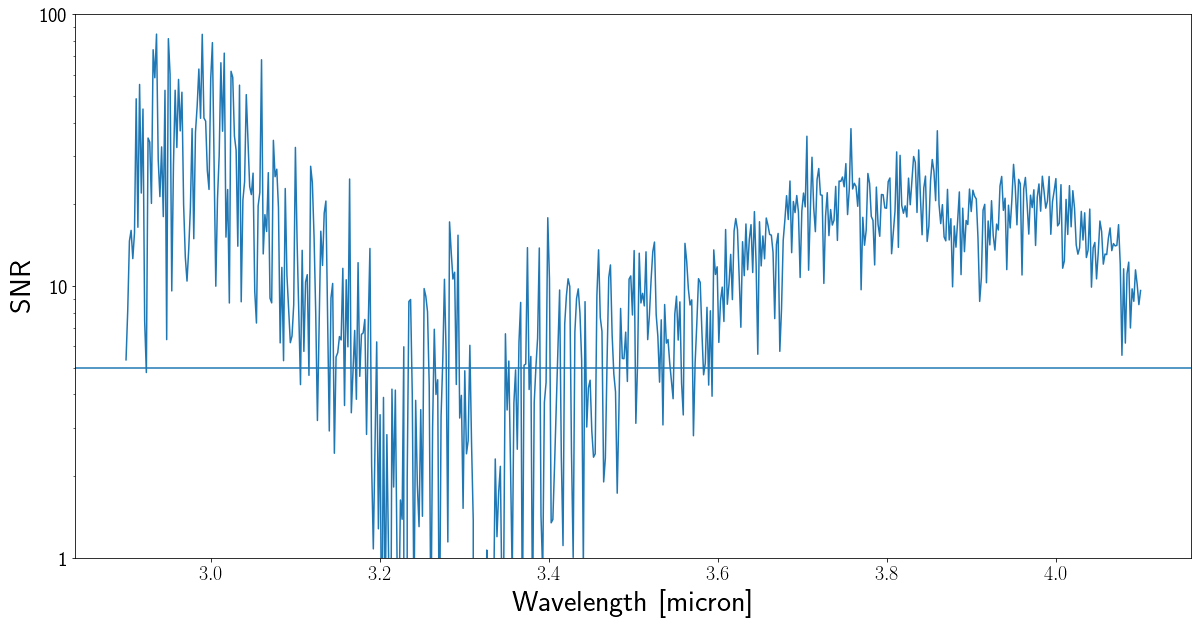

In [424]:
import matplotlib, matplotlib.ticker as mticker
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.figure(figsize=(20,10))
plt.plot(fp.lam,SNR)
plt.yscale('log')
plt.axhline(5)
plt.ylim(1,100)
plt.ylabel('SNR', size=30)
plt.xlabel('Wavelength [micron]', size=30)
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:g}"))

# K band

In [382]:
Kfilter = Filter()
Kfilter.y[(Kfilter.x.value >= 1.99) & (Kfilter.x.value <= 2.41)] = .9

Nlam = 600
keck_cube = np.zeros((Nlam, 18, 18))
for i, mag in enumerate(np.linspace(2,2.4,Nlam)):
    W = DFT_matrix(160, 22.8*mag)
    A = pupil.pupil * np.exp(1.j * screen1)
    out = abs(W.dot(A).dot(W))**2
    keck_cube[i] = frebin(out, (18, 18))
    keck_cube[i] /= keck_cube[i].max()

In [383]:
args_new = {'Lenslet_object':lens,
               'SkyBG':skybg,
               'SkyTrans':skytrans,
               'InstTransEm':inst,
               'Filter':Kfilter,
               'QE':qe}

In [384]:
%run focal_plane_sim/focal_plane.py
fp = FocalPlane(args_new)
fp.num_spaxel = 18
fp.area = 76*u.m**2
fp.fov = (.36 * u.arcsec)**2
fp.lam = np.linspace(2,2.4,Nlam) * u.micron
fp.dlam = np.gradient(fp.lam)
bg_truth = fp.get_fp(dit, return_full=False)

<Figure size 432x288 with 0 Axes>

In [385]:
mask = make_mask(center=(9,9), radius=5, size=(18,18))#mask = make_mask(center=(15,15), radius=4, size=(30,30))
print(flag)
temp = flag[0]*u.K
logg = flag[1]*u.dimensionless_unscaled

star = Target(temp, logg, 40.9*u.pc, file_type='C')
dit = 1 * u.s

bg_truth = fp.get_fp(dit, return_full=False)

bg_star_truth = fp.get_fp(dit, Target=star, PSF=keck_cube, return_full=False)

N_obj = 30
N_sky = 30
N_cal = 5


BG_stack = []
Obj_stack = []
SNR = [0]
N_pattern=1
detected = 0
detected1=0
total_time = 0*u.s
while (total_time.value < 2*3600):#(not sum(np.array(SNR) > 5)>500) & (total_time.value < 5*3600):
    total_time = (dit*N_obj + dit*N_sky + dit*N_cal)*N_pattern

    for pat in range(N_pattern - len(BG_stack)):
        bgobjstack = np.median([noisy_small(bg_star_truth) for i in range(N_obj)], axis=0)
        bgstack = np.median([noisy_small(bg_truth) for i in range(N_sky)], axis=0)
        Obj_stack.append(bgobjstack - bgstack)
        BG_stack.append(bgstack)

    final_obj = np.median(Obj_stack, axis=0)
    final_bg = np.median(BG_stack, axis=0)

    SNR = []
    for i in range(Nlam):
        bg_masked = mask * final_bg[i]
        obj_masked = mask * final_obj[i]
        snr = np.nansum(obj_masked) / np.nanstd(bg_masked)/np.pi/5**2
        SNR.append(snr)
    snr1 = np.nansum(mask * final_obj.sum(0)) / np.nanstd(mask*final_bg.sum(0))/np.pi/5**2
    if (snr1 > 5) & (not detected1):
        detected1=1
        print('{} {} detected in collapsed cube after {}'.format(temp, logg, total_time))
    if any(np.array(SNR) > 5) & (not detected):
        detected = 1
        #first_detection[logg_ind, temp_ind] = total_time.value
        print('{} {} detected in single after {}'.format(temp, logg, total_time))
    N_pattern +=1
#five_sigma_in_all[logg_ind, temp_ind] = total_time.value
print('{} {} detected in all after {}'.format(temp, logg, total_time))


[1000, 4.0]
1000.0 K 4.0 detected in collapsed cube after 65.0 s
1000.0 K 4.0 detected in single after 65.0 s
1000.0 K 4.0 detected in all after 7215.0 s


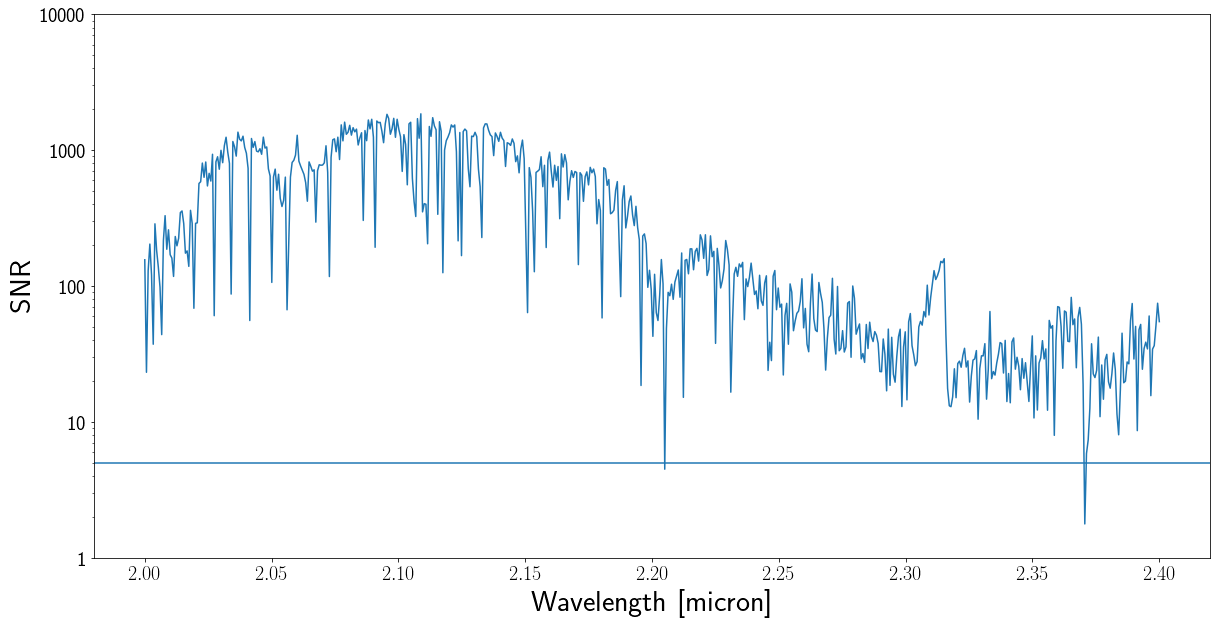

In [389]:
import matplotlib, matplotlib.ticker as mticker
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.figure(figsize=(20,10))
plt.plot(fp.lam,SNR)
plt.yscale('log')
plt.axhline(5)
plt.ylim(1,10000)
plt.ylabel('SNR', size=30)
plt.xlabel('Wavelength [micron]', size=30)
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:g}"))

# M band

In [372]:
Mfilter = Filter()
Mfilter.y[(Mfilter.x.value >= 4.49) & (Mfilter.x.value <= 5.21)] = .9

Nlam = 600
keck_cube = np.zeros((Nlam, 18, 18))
for i, mag in enumerate(np.linspace(4.5,5.2,Nlam)):
    W = DFT_matrix(160, 22.8*mag)
    A = pupil.pupil * np.exp(1.j * screen1)
    out = abs(W.dot(A).dot(W))**2
    keck_cube[i] = frebin(out, (18, 18))
    keck_cube[i] /= keck_cube[i].max()

In [373]:
args_new = {'Lenslet_object':lens,
               'SkyBG':skybg,
               'SkyTrans':skytrans,
               'InstTransEm':inst,
               'Filter':Mfilter,
               'QE':qe}

In [374]:
%run focal_plane_sim/focal_plane.py
fp = FocalPlane(args_new)
fp.num_spaxel = 18
fp.area = 76*u.m**2
fp.fov = (.36 * u.arcsec)**2
fp.lam = np.linspace(4.5,5.2,Nlam) * u.micron
fp.dlam = np.gradient(fp.lam)
bg_truth = fp.get_fp(dit, return_full=False)

<Figure size 432x288 with 0 Axes>

In [375]:

mask = make_mask(center=(9,9), radius=5, size=(18,18))#mask = make_mask(center=(15,15), radius=4, size=(30,30))
print(flag)
temp = flag[0]*u.K
logg = flag[1]*u.dimensionless_unscaled

star = Target(temp, logg, 40.9*u.pc, file_type='C')
dit = 1 * u.s

bg_truth = fp.get_fp(dit, return_full=False)

bg_star_truth = fp.get_fp(dit, Target=star, PSF=keck_cube, return_full=False)

N_obj = 30
N_sky = 30
N_cal = 5


BG_stack = []
Obj_stack = []
SNR = [0]
N_pattern=1
detected = 0
detected1=0
total_time = 0*u.s
while (total_time.value < 2*3600):#(not sum(np.array(SNR) > 5)>500) & (total_time.value < 5*3600):
    total_time = (dit*N_obj + dit*N_sky + dit*N_cal)*N_pattern

    for pat in range(N_pattern - len(BG_stack)):
        bgobjstack = np.median([noisy_small(bg_star_truth) for i in range(N_obj)], axis=0)
        bgstack = np.median([noisy_small(bg_truth) for i in range(N_sky)], axis=0)
        Obj_stack.append(bgobjstack - bgstack)
        BG_stack.append(bgstack)

    final_obj = np.median(Obj_stack, axis=0)
    final_bg = np.median(BG_stack, axis=0)

    SNR = []
    for i in range(Nlam):
        bg_masked = mask * final_bg[i]
        obj_masked = mask * final_obj[i]
        snr = np.nansum(obj_masked) / np.nanstd(bg_masked)/np.pi/5**2
        SNR.append(snr)
    snr1 = np.nansum(mask * final_obj.sum(0)) / np.nanstd(mask*final_bg.sum(0))/np.pi/5**2
    if (snr1 > 5) & (not detected1):
        detected1=1
        print('{} {} detected in collapsed cube after {}'.format(temp, logg, total_time))
    if any(np.array(SNR) > 5) & (not detected):
        detected = 1
        #first_detection[logg_ind, temp_ind] = total_time.value
        print('{} {} detected in single after {}'.format(temp, logg, total_time))
    N_pattern +=1
#five_sigma_in_all[logg_ind, temp_ind] = total_time.value
print('{} {} detected in all after {}'.format(temp, logg, total_time))


[1000, 4.0]
1000.0 K 4.0 detected in collapsed cube after 65.0 s
1000.0 K 4.0 detected in single after 910.0 s
1000.0 K 4.0 detected in all after 7215.0 s


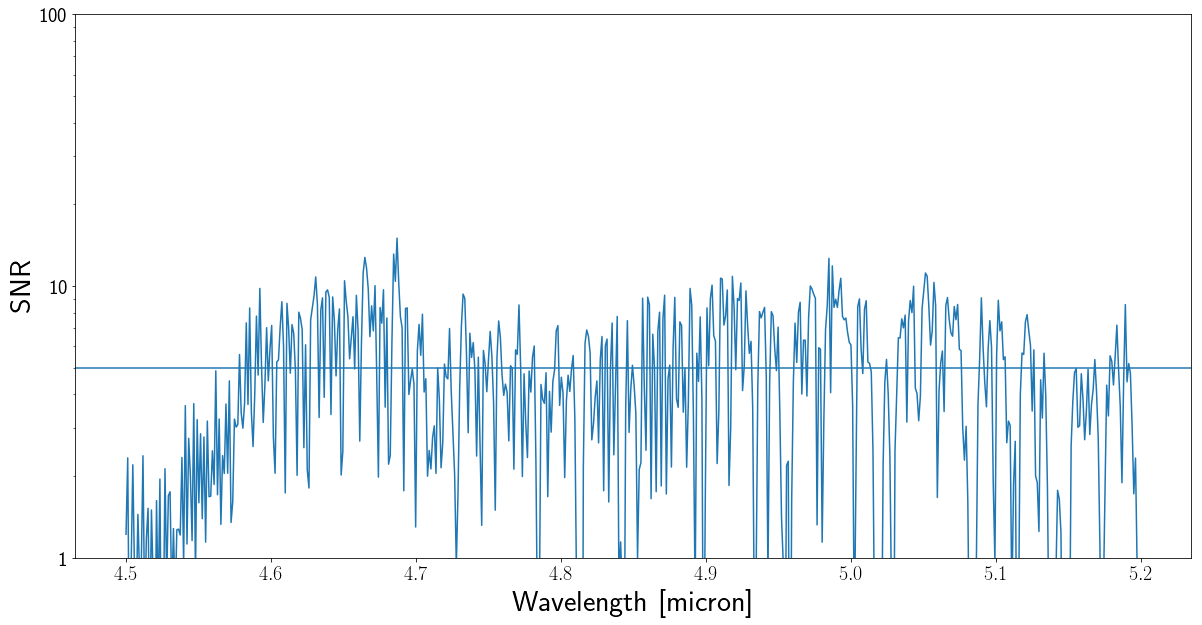

In [376]:
import matplotlib, matplotlib.ticker as mticker
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.figure(figsize=(20,10))
plt.plot(fp.lam,SNR)
plt.yscale('log')
plt.axhline(5)
plt.ylim(1,100)
plt.ylabel('SNR', size=30)
plt.xlabel('Wavelength [micron]', size=30)
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:g}"))